### Imports

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import cycle
from IPython.display import clear_output
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from nltk import word_tokenize

### Import dataset 

In [2]:
prof = open("data\Csv_Profesiones_02.csv",encoding="utf8")

ls = prof.readline().lower()

lines_without_anotation = []
lines_with_anotation = []
lines_with_error = []

while ls:
    text = ls.replace("\n","")
    tx = text.lower().split("||")
    if len(tx) <= 2:
        lines_without_anotation.append(tx)
    elif len(tx) == 4:
        tx[2] = tx[2].replace('|','')
        tx[2] = tx[2].replace(' ','')
        tx[3] = tx[3].replace('|','')
        tx[3] = tx[3].replace(' ','')
        lines_with_anotation.append(tx)
    else:
        lines_with_error.append(tx)
    ls = prof.readline().lower()

df_without = pd.DataFrame(lines_without_anotation, columns=('id', 'text'))
df_with = pd.DataFrame(lines_with_anotation, columns=('id', 'text','category_1', 'category_2'))
df_error = pd.DataFrame(lines_with_error)

print(df_without.shape)
print(df_with.shape)
print(df_error.shape)       

(23820, 2)
(4612, 4)
(115, 9)


### Analyze data

In [3]:
df = pd.DataFrame(df_with, columns=('id', 'text','category_1', 'category_2'))
df.shape

(4612, 4)

In [4]:
df.category_1.unique()

array(['b', '2', 'a', '3', '1', '5', '0', 'aa', '4', '6', '8', '7'],
      dtype=object)

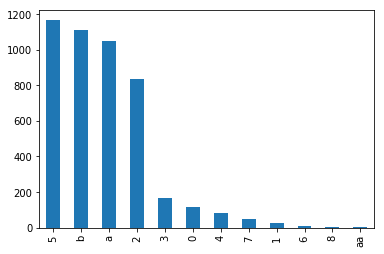

In [5]:
df['category_1'].value_counts().plot(kind='bar')
plt.show()

In [6]:
def reduce_labels_profesion(fraction, df):
    otros = []
    min_len = len(df['category_1'])*fraction
    for key in df['category_1'].value_counts().keys():
        
        if df['category_1'].value_counts()[key] < min_len:
            otros.append(key)
        else:
            pass
    return otros

def change_labels_profesion(df, otros):
    for i, row in df.iterrows():
          if row['category_1'] in otros:
            df.loc[i, 'category_1'] = 'others'
            
others = reduce_labels_profesion(0.0015, df)
change_labels_profesion(df, others)

In [7]:
df['category_1'].value_counts()

5         1164
b         1112
a         1049
2          835
3          168
0          115
4           81
7           50
1           25
6           10
others       3
Name: category_1, dtype: int64

### Create split train/test

In [8]:
train, test = train_test_split(df, test_size=0.15, random_state=42)

### Encode Labels

In [9]:
lb = LabelEncoder()
y_train = lb.fit_transform(train['category_1'].tolist())
y_test = lb.transform(test['category_1'].tolist())

n_classes = len(lb.classes_)

print('Numero de clases en train: {}'.format(n_classes))
print('Cantidad de datos en entrenamiento: {}'.format(y_train.shape[0]))
print('Cantidad de datos en prueba: {}'.format(y_test.shape[0]))

Numero de clases en train: 11
Cantidad de datos en entrenamiento: 3920
Cantidad de datos en prueba: 692


### Training

In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
class Stopwords(BaseEstimator, TransformerMixin):
    """ERemove stopwords from each text"""

    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        result = []
        for text in texts:
            text_stopwords_removed = [i for i in word_tokenize(text.lower()) if i not in stop] 
            result.append(' '.join(text_stopwords_removed))
        return result

In [12]:
class ItemSelector(BaseEstimator,TransformerMixin):

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [13]:
nltk.download('punkt')
pipeline = Pipeline([
    ('selector', ItemSelector(key='text')),
    ('StopWords',Stopwords()),
    ('vect', CountVectorizer(max_features=None, ngram_range=(1, 2) )),
    ('tfidf', TfidfTransformer()),
    # Use a SVC classifier on the combined features
    ('clf', CalibratedClassifierCV(LinearSVC(random_state=42, multi_class='ovr'))),
])
pipeline.fit(train, y_train)
print('Finished training')
joblib.dump(pipeline, 'model_profession.pkl') 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Finished training


['model_profession.pkl']

In [14]:
y_score = pipeline.predict_proba(test)

In [15]:
def convertToOneHot(vector, num_classes=None):
    """
    Converts an input 1-D vector of integers into an output
    2-D array of one-hot vectors, where an i'th input value
    of j will set a '1' in the i'th row, j'th column of the
    output array.

    Example:
        v = np.array((1, 0, 4))
        one_hot_v = convertToOneHot(v)
        print one_hot_v

        [[0 1 0 0 0]
         [1 0 0 0 0]
         [0 0 0 0 1]]
    """

    assert isinstance(vector, np.ndarray)
    assert len(vector) > 0

    if num_classes is None:
        num_classes = np.max(vector)+1
    else:
        assert num_classes > 0
        assert num_classes >= np.max(vector)

    result = np.zeros(shape=(len(vector), num_classes))
    result[np.arange(len(vector)), vector] = 1
    return result.astype(int)

### F1 Score

In [16]:
f1_score(y_test, [np.argmax(i) for i in y_score], average = "micro") 

0.8049132947976878

### Average precision

In [17]:
y_eval = convertToOneHot(y_test, num_classes=n_classes)

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_eval[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_eval[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_eval.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_eval, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.87


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:526: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


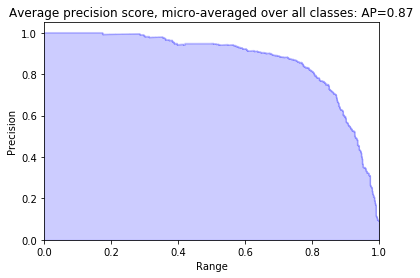

In [18]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                 color='b')

plt.xlabel('Range')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
plt.show()

### Test

In [22]:
m_profession = joblib.load('model_profession.pkl')
df_new = pd.DataFrame(columns=('id', 'text'))
df_new = df_new.append({'id': 1, 'text': 'medico', }, ignore_index=True)
y_new = m_profession.predict(df_new)
print(y_new[0])

2
